In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets,models,optimizers,layers
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential,Model
from sklearn.model_selection import train_test_split 
from tensorflow.keras.losses import msle
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,...,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,...,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,...,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.461101,0.664659,0.587757,0.701325,0.917205,1.247987,1.505568,1.640105,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0

In [2]:
data.shape

(4998, 141)

In [9]:
x = data.iloc[0:,0:140]
y = data.iloc[0:,140:]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y)
train_index = y_train[y_train==1].index
x_train = x_train.loc[train_index]

In [10]:
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train.copy())
x_test = min_max_scaler.transform(x_test.copy())

In [20]:
class Autoencoder(Model):
    def __init__(self,output_units):
        super().__init__()
        self.encoder = Sequential([
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(8,activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(output_units,activation='sigmoid')
        ])
        
    def call(self,inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
model = Autoencoder(output_units=x_train.shape[1])
model.compile(loss = 'msle',optimizer='adam',metrics=['mse'])
h = model.fit(x_train,y_train,epochs=20,batch_size=512,validation_data=(x_test,y_test))

Epoch 1/20
8/8 [==============================] - 1s 42ms/step - loss: 0.1167 - mse: 0.2497 - val_loss: 0.1164 - val_mse: 0.2490
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.1160 - mse: 0.2477 - val_loss: 0.1146 - val_mse: 0.2437
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.1135 - mse: 0.2404 - val_loss: 0.1090 - val_mse: 0.2280
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.1063 - mse: 0.2193 - val_loss: 0.0969 - val_mse: 0.1935
Epoch 5/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0934 - mse: 0.1809 - val_loss: 0.0816 - val_mse: 0.1465
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0797 - mse: 0.1400 - val_loss: 0.0727 - val_mse: 0.1180
Epoch 7/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0721 - mse: 0.1183 - val_loss: 0.0670 - val_mse: 0.1052
Epoch 8/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0669 - mse: 0.1067 - val_los

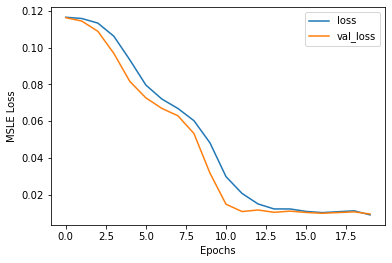

In [23]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [29]:
def find_threshold(model,x_train):
    reconstructions = model.predict(x_train)
    reconstruction_errors = tf.keras.losses.msle(reconstructions,x_train)
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold
def get_predictions(model,x_test,threshold):
    predictions = model.predict(x_test)
    errors = tf.keras.losses.msle(predictions,x_test)
    anomaly_mask = pd.Series(errors)>threshold
    preds = anomaly_mask.map(lambda x:0.0 if x==True else 1.0)
    return preds
threshold = find_threshold(model,x_train)
print(f"threshold :{threshold}")    

125/125 [==============================] - 0s 1ms/step
threshold :0.19667607792548086


In [30]:
predictions = get_predictions(model,x_test,threshold)
accuracy_score(predictions,y_test)

32/32 [==============================] - 0s 1ms/step


0.932